In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from sklearn.model_selection import train_test_split

## Open MNIST data and create a subset with desired digits
MNIST dataset contains 70,000 images of hand-written digits from 0 to 9. Each image has a grey-scale resolution of 28 $\times$ 28 (i.e., 784 pixels). Each pixel has an integer value ranging from 0 (bright) to 255 (dark).

<font color=red>Change the code below to select a different subset </font>

In [13]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

# Change the conditions below to compare between other two digits.
class1Indices = (y==0)
class2Indices = (y==1)

x1 = X[class1Indices]
x2 = X[class2Indices]

Xtrain = np.concatenate((x1,x2),axis=0)
ytrain = np.concatenate((np.zeros(x1.shape[0]),np.ones(x2.shape[0])),axis=0)

# Saving the temporary variables for fast retrieval
with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)



AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)

# Split the data to training, testing, and validation subsets

In [ ]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)
    
# Split the data to training, testing, and validation subsets
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.14, random_state=1) # 0.25 x 0.8 = 0.2

Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]


# Accuracy of a classifier

In [ ]:
def testLinearClassifier(a,X,y):
    # YOUR CODE HERE (2.)
    predictions = (X @ a[:-1] + a[-1]) > 0
    misclassifications = np.sum(predictions != y)
    print(f"Mis-classifications = {misclassifications} out of {y.size} equivalent to {misclassifications/(y.size) * 100} %")
    return misclassifications

## Define and test gaussianClassifierWithIdentityCovariance 

In [ ]:
#------TRAINING CODE --------------
def gaussianClassifierWithIdentityCovariance(Xtrain,ytrain):
    # YOUR CODE HERE (3.)
    X1 = Xtrain[ytrain == 0]
    X2 = Xtrain[ytrain == 1]
    # means
    mu1 = np.mean(X1, axis=0)
    mu2 = np.mean(X2, axis=0)
    # priors
    p1 = X1.shape[0] / Xtrain.shape[0]
    p2 = X2.shape[0] / Xtrain.shape[0]
    w = mu2 - mu1
    w0 = -0.5 * (np.dot(mu2, mu2) - np.dot(mu1, mu1)) + np.log(p2 / p1)
    a = np.hstack((w, w0))
    return a

#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = gaussianClassifierWithIdentityCovariance(X_train,y_train)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)

# testing to verify results
# from sklearn.naive_bayes import GaussianNB
# gnb = GaussianNB()
# gnb.fit(X_train, y_train)
# train_predictions = gnb.predict(X_train)
# val_predictions = gnb.predict(X_val)
# test_predictions = gnb.predict(X_test)
# train_misclassifications = np.sum(train_predictions != y_train)
# val_misclassifications = np.sum(val_predictions != y_val)
# test_misclassifications = np.sum(test_predictions != y_test)
# print(train_misclassifications)
# print(val_misclassifications)
# print(test_misclassifications)

## Define and test gaussianClassifierWithCommonCovariance 

In [ ]:
#------TRAINING CODE --------------
def gaussianClassifierWithCommonCovariance(Xtrain,ytrain):
    # YOUR CODE HERE (4.)
    X1 = Xtrain[ytrain == 0]
    X2 = Xtrain[ytrain == 1]
    # means
    mu1 = np.mean(X1, axis=0)
    mu2 = np.mean(X2, axis=0)
    # priors
    p1 = X1.shape[0] / Xtrain.shape[0]
    p2 = X2.shape[0] / Xtrain.shape[0]

    cov1 = np.cov(X1, rowvar=False)
    cov2 = np.cov(X2, rowvar=False)
    sigma = (p1 * cov1 + p2 * cov2)
    sigma += np.eye(sigma.shape[0]) * 1 # add regularization term ?
    
    sigma_inv = np.linalg.inv(sigma)

    w = np.dot(sigma_inv, mu2 - mu1)
    w0 = (-0.5 * (np.dot(mu2, np.dot(sigma_inv, mu2)) - np.dot(mu1, np.dot(sigma_inv, mu1))) + np.log(p2 / p1))
    a = np.hstack((w, w0))
    return a
    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = gaussianClassifierWithCommonCovariance(X_train,y_train)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)


## Define and test logisticRegression 

You may choose the step size as 1e-4. You can try changing it.

Use the expit() function from scipy.special.expit to implement sigmoid without overflow errors 

In [ ]:
def logisticRegression(Xtrain,ytrain,iterations=100,step_size=1e-4,verbose=False):
    # YOUR CODE HERE (5.)
    X_bias = np.hstack((Xtrain, np.ones((Xtrain.shape[0], 1))))
    # a = 0.01 * np.random.randn(X_bias.shape[1]) # initialize weights randomly (?)
    a = np.zeros(Xtrain.shape[1] + 1)
    
    for i in range(iterations):
        z = np.dot(X_bias, a)
        predictions = expit(z)

        gradient = np.dot(X_bias.T, (predictions - ytrain)) / ytrain.size
        a -= step_size * gradient

        if verbose and i % (iterations // 10) == 0:
            loss = -np.mean(ytrain * np.log(predictions + 1e-8) + (1 - ytrain) * np.log(1 - predictions + 1e-8))
            print(f"Iteration {i}: Loss = {loss:.6f}")
    
    return a
    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = logisticRegression(X_train,y_train,iterations=500,verbose=False)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)


In [ ]:
def logisticRegressionWithRegularization(Xtrain,ytrain,iterations=100,step_size=1e-4,lam=1,verbose=False):
    # YOUR CODE HERE (6.)
    X_bias = np.hstack((Xtrain, np.ones((Xtrain.shape[0], 1))))

    a = np.zeros(Xtrain.shape[1] + 1)

    for i in range(iterations):
        z = np.dot(X_bias, a)
        predictions = expit(z)
        gradient = np.dot(X_bias.T, (predictions - ytrain)) / ytrain.size
        regularization = lam * a
        regularization[-1] = 0
        a -= step_size * (gradient + regularization)

        if verbose and i % (iterations // 10) == 0:
            # Compute regularized loss (logistic cost + L2 regularization)
            loss = (-np.mean(ytrain * np.log(predictions + 1e-8) + (1 - ytrain) * np.log(1 - predictions + 1e-8)) +
                    (lam / (2 * ytrain.size)) * np.sum(a[:-1] ** 2))
            print(f"Iteration {i}: Loss = {loss:.6f}")

    return a
    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = logisticRegressionWithRegularization(X_train,y_train,iterations=500,verbose=False,lam=1)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)

In [ ]:
def optimizeHyperparameters(Xtrain,ytrain, Xval, yval, Xtest, ytest, lambdas, iterations=500, step_size=1e-4):
    # YOUR CODE HERE (7.)
    lamopt = None
    lowest_misclassifications = float('inf')

    for lam in lambdas:
        a = logisticRegressionWithRegularization(Xtrain, ytrain, iterations=iterations, step_size=step_size, lam=lam)
        misclassifications = testLinearClassifier(a,Xval,yval)
        if misclassifications < lowest_misclassifications:
            lowest_misclassifications = misclassifications
            lamopt = lam

    a4 = logisticRegressionWithRegularization(Xtrain, ytrain, iterations=iterations, step_size=step_size, lam=lamopt)

    # Evaluate on the test dataset
    Xtest_bias = np.hstack((Xtest, np.ones((Xtest.shape[0], 1))))
    test_predictions = (expit(np.dot(Xtest_bias, a4)) >= 0.5).astype(int)
    test_accuracy = np.mean(test_predictions == ytest)

    return lamopt, a4, (test_accuracy * 100)  

lambdas = [0.01, 0.1, 1, 10, 100]
# lambdas = [100, 10, 1, 0.1, 0.01]
lamopt, a4, test_accuracy = optimizeHyperparameters(X_train, y_train, X_val, y_val, X_test, y_test, lambdas)
print("Optimal λ:", lamopt)
print("Test Accurary:", test_accuracy)

# REPORT TEST ERRORS OF THE BEST MODELS

YOUR CODE BELOW

In [ ]:
def compareClassifiers(Xtrain, ytrain, Xval, yval, Xtest, ytest, lambdas, iterations=500, step_size=1e-4):
    a1 = gaussianClassifierWithIdentityCovariance(Xtrain, ytrain)
    misclassifications_a1 = testLinearClassifier(a1, Xtest, ytest)

    a2 = gaussianClassifierWithCommonCovariance(Xtrain, ytrain)
    misclassifications_a2 = testLinearClassifier(a2, Xtest, ytest)

    a3 = logisticRegression(Xtrain, ytrain, iterations=iterations, step_size=step_size)
    misclassifications_a3 = testLinearClassifier(a3, Xtest, ytest)

    lamopt, a4, test_accuracy = optimizeHyperparameters(Xtrain, ytrain, Xval, yval, Xtest, ytest, lambdas, iterations=iterations, step_size=step_size)
    misclassifications_a4 = testLinearClassifier(a4, Xtest, ytest)

    # results
    print("\nPerformance Summary:")
    print(f"Gaussian Classifier (Identity Covariance, a1): {misclassifications_a1} misclassifications")
    print(f"Gaussian Classifier (Common Covariance, a2): {misclassifications_a2} misclassifications")
    print(f"Logistic Regression (a3): {misclassifications_a3} misclassifications")
    print(f"Regularized Logistic Regression (a4, λ={lamopt}): {misclassifications_a4} misclassifications")
    
    return {
        "a1_misclassifications": misclassifications_a1,
        "a2_misclassifications": misclassifications_a2,
        "a3_misclassifications": misclassifications_a3,
        "a4_misclassifications": misclassifications_a4,
        "a4_lambda_optimal": lamopt,
        "a4_test_accuracy": test_accuracy,
    }


lambdas = [0.01, 0.1, 1, 10, 100]
results = compareClassifiers(X_train, y_train, X_val, y_val, X_test, y_test, lambdas)
print(results)

# Component 2

1. Load the MNIST dataset. Split this dataset into training (70%), validation (10%), and test dataset
(20%).

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from sklearn.model_selection import train_test_split

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

Xtrain = X
ytrain = y

# Saving the temporary variables for fast retrieval
with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)

In [9]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)
    
# Split the data to training, testing, and validation subsets
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.14, random_state=1) # 0.25 x 0.8 = 0.2

Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]

2. Develop a python function called gaussianMultiChannelClassifier

Matrix A2 shape: (785, 10)


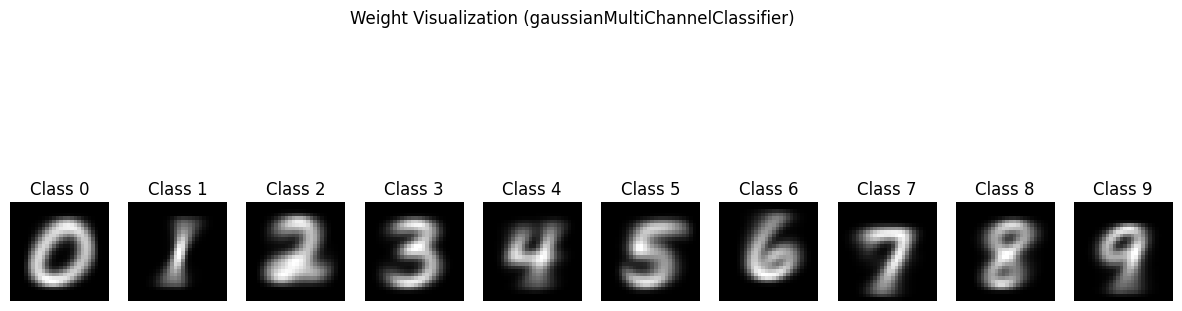

In [10]:
#------TRAINING CODE --------------
def gaussianMultiChannelClassifier(Xtrain, ytrain):
    n_classes = len(np.unique(ytrain))
    n_features = Xtrain.shape[1]
    A1 = np.zeros((n_features + 1, n_classes))

    for i in range(n_classes):
        X_i = Xtrain[ytrain == i]
        mu_i = np.mean(X_i, axis=0)
        prior_i = X_i.shape[0] / Xtrain.shape[0]
        w = mu_i  # Σ = I -> w = μ_i
        w0 = -0.5 * np.dot(mu_i, mu_i) + np.log(prior_i)
        A1[:-1, i] = w
        A1[-1, i] = w0

    return A1

#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
A1 = gaussianMultiChannelClassifier(X_train, y_train)
print("Matrix A2 shape:", A1.shape)
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    weights = A1[:-1, i]
    image = np.reshape(weights, (28, 28))
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Class {i}")
    axes[i].axis('off')

plt.suptitle("Weight Visualization (gaussianMultiChannelClassifier)")
plt.show()

3. Develop a python function called logisticRegressionMultiClassClassifier

In [ ]:
#------TRAINING CODE --------------
def logisticRegressionMultiClassClassifier(Xtrain, ytrain, iterations=1000, step_size=1e-3):
    n_samples, n_features = Xtrain.shape
    n_classes = len(np.unique(ytrain))
    X_bias = np.hstack((Xtrain, np.ones((n_samples, 1))))
    # One-hot encode the labels
    Y_onehot = np.zeros((n_samples, n_classes))
    Y_onehot[np.arange(n_samples), ytrain.astype(int)] = 1
    
    A2 = np.zeros((n_features + 1, n_classes))
    # Gradient descent
    for _ in range(iterations):
        scores = np.dot(X_bias, A2)
        
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        gradient = np.dot(X_bias.T, (probabilities - Y_onehot)) / n_samples
        A2 -= step_size * gradient

    return A2

#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
A2 = logisticRegressionMultiClassClassifier(X_train, y_train)
print("Matrix A2 shape:", A2.shape)

fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    weights = A2[:-1, i]
    image = np.reshape(weights, (28, 28))
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Class {i}")
    axes[i].axis('off')

plt.suptitle("Learned Weights for Each Class (Logistic Regression)")
plt.show()

4. Develop a python function called logisticRegressionMultiClassClassifierWithRegularization

In [ ]:
#------TRAINING CODE --------------
def logisticRegressionMultiClassClassifierWithRegularization(Xtrain, ytrain, lam = 0.1, iterations=100, step_size=1e-3):
    n_samples, n_features = Xtrain.shape
    n_classes = len(np.unique(ytrain))
    
    # Add a bias term to the feature matrix
    X_bias = np.hstack((Xtrain, np.ones((n_samples, 1))))
    
    # One-hot encode the labels
    Y_onehot = np.zeros((n_samples, n_classes))
    Y_onehot[np.arange(n_samples), ytrain.astype(int)] = 1
    
    # Initialize weights randomly for all classes
    A3 = np.zeros((n_features + 1, n_classes))
    
    # Gradient descent
    for _ in range(iterations):
        # Compute the scores for all classes
        scores = np.dot(X_bias, A3)  # Shape: [n_samples, n_classes]
        
        # Apply the softmax function
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))  # Stability trick
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # Compute the gradient
        gradient = np.dot(X_bias.T, (probabilities - Y_onehot)) / n_samples
        
        # Add regularization (excluding the bias term)
        gradient[:-1] += lam * A3[:-1]  # Regularize only weights, not bias
        
        # Update the weights
        A3 -= step_size * gradient

    return A3

#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
A3 = logisticRegressionMultiClassClassifierWithRegularization(X_train, y_train, lam=0.1)
print("Matrix A3 shape:", A3.shape)  # Should be (n_features + 1, n_classes)

fig, axes = plt.subplots(1, 10, figsize=(15, 5))  # Assuming 10 classes (digits 0–9)
for i in range(10):
    weights = A3[:-1, i]  # Exclude the bias term
    image = np.reshape(weights, (28, 28))  # Reshape to 28x28 for MNIST
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Class {i}")
    axes[i].axis('off')

plt.suptitle("Learned Weights for Each Class (Regularized Logistic Regression)")
plt.show()


5. Write a function Optimize_MC_Hyperparameters to determine the optimal λ of logisticRegressionMultiClassClassifierWithRegularization.

In [ ]:
#------TRAINING CODE --------------
def Optimize_MC_Hyperparameters(Xtrain, ytrain, Xval, yval, lambdas, iterations=100, step_size=1e-3):

    best_lambda = None
    lowest_misclassifications = float('inf')

    for lam in lambdas:
        # Train the model with the current λ
        A3 = logisticRegressionMultiClassClassifierWithRegularization(
            Xtrain, ytrain, lam=lam, iterations=iterations, step_size=step_size
        )
        
        # Evaluate on the validation dataset
        Xval_bias = np.hstack((Xval, np.ones((Xval.shape[0], 1))))  # Add bias term
        scores = np.dot(Xval_bias, A3)  # Compute scores for each class
        predictions = np.argmax(scores, axis=1)  # Predict the class with the highest score
        misclassifications = np.sum(predictions != yval)  # Count misclassifications
        
        # Update the best λ if the current one is better
        if misclassifications < lowest_misclassifications:
            lowest_misclassifications = misclassifications
            best_lambda = lam

    # Train the model on the full training set using the optimal λ
    A4 = logisticRegressionMultiClassClassifierWithRegularization(
        Xtrain, ytrain, lam=best_lambda, iterations=iterations, step_size=step_size
    )
    
    print(f"Best Lambda: {best_lambda}")
    return A4

#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
lambdas = [0.01, 0.1, 1, 10, 100]
A4 = Optimize_MC_Hyperparameters(X_train, y_train, X_val, y_val, lambdas)
print("Matrix A4 shape:", A4.shape)

6. Write a function testLinearMCClassifier to test the performance of a multiclass classifier specified by its weights A.

In [ ]:
def testLinearMCClassifier(A, X, y):
    Xtest_bias = np.hstack((X, np.ones((X.shape[0], 1))))
    scores = np.dot(Xtest_bias, A)
    predictions = np.argmax(scores, axis=1)
    misclassifications = np.sum(predictions != y)
    print(f"Mis-classifications = {misclassifications} out of {y.size} equivalent to {misclassifications/(y.size) * 100} %")
    return misclassifications


7. Write a script that would compare the performance all the above algorithms on the test subset.

In [ ]:
# Each prints results out by training, validation, and then test data
# A1
print("A1")
testLinearMCClassifier(A1, X_train, y_train)
testLinearMCClassifier(A1, X_val, y_val)
testLinearMCClassifier(A1, X_test, y_test)
# A2
print("A2")
testLinearMCClassifier(A2, X_train, y_train)
testLinearMCClassifier(A2, X_val, y_val)
testLinearMCClassifier(A2, X_test, y_test)
# A3
print("A3")
testLinearMCClassifier(A3, X_train, y_train)
testLinearMCClassifier(A3, X_val, y_val)
testLinearMCClassifier(A3, X_test,y_test)
# A4
print("A4")
testLinearMCClassifier(A4, X_train, y_train)
testLinearMCClassifier(A4, X_val, y_val)
testLinearMCClassifier(A4, X_test, y_test)

# Component 3

1. Load the MNIST dataset. Split this dataset into training (70%), validation (10%), and test dataset
(20%).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

# Change the conditions below to compare between other two digits.
class1Indices = (y==0)
class2Indices = (y==1)

x1 = X[class1Indices]
x2 = X[class2Indices]

Xtrain = np.concatenate((x1,x2),axis=0)
ytrain = np.concatenate((np.zeros(x1.shape[0]),np.ones(x2.shape[0])),axis=0)

# Saving the temporary variables for fast retrieval
with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)

In [2]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)
    
# Split the data to training, testing, and validation subsets
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.14, random_state=1) # 0.25 x 0.8 = 0.2

Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]

2. Use a linear kernel support vector machine to classify the above data.

- Extract the support vectors and display them as 28x28 images. For the 0-1 classification, you
would get 76 support vectors, which can be displayed as 63 images. These are the hardest images
to classify.

Number of support vectors: 69


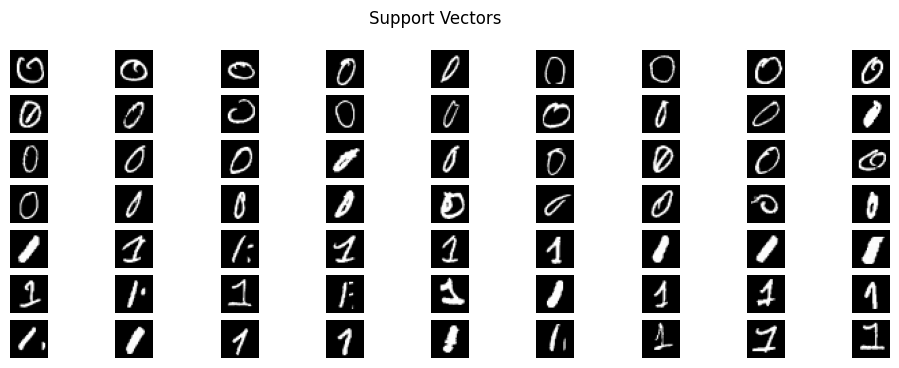

In [3]:
model = SVC(kernel='linear', C=1E10)
model.fit(X_train, y_train)

support_vectors = model.support_vectors_
n_support = len(support_vectors)
print(f"Number of support vectors: {n_support}")

fig, axes = plt.subplots(7, 9, figsize=(12, 4))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(support_vectors[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.suptitle("Support Vectors")
plt.show()


- Plot the dual coefficients or Lagrange multipliers using the attribute `dual_coef_`, which corresponds to the weights for the support vectors.

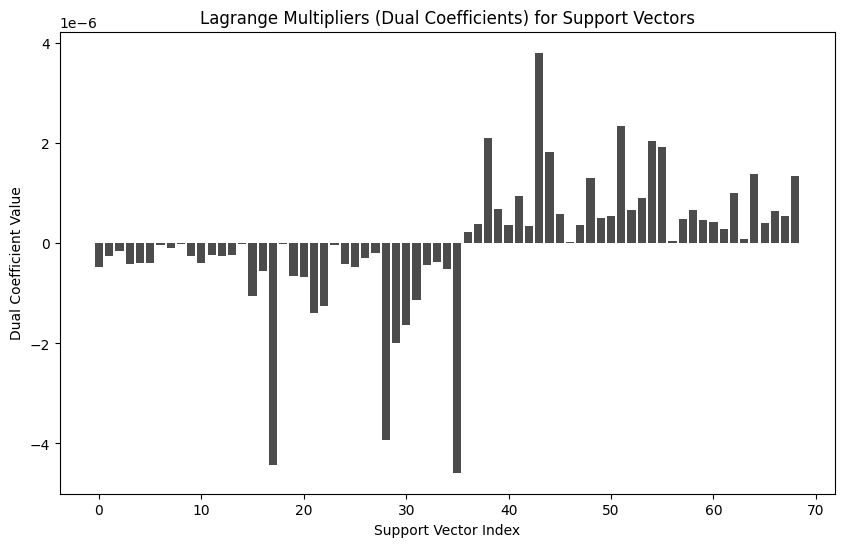

In [4]:
dual_coef = model.dual_coef_[0] 
support_indices = model.support_

plt.figure(figsize=(10, 6))
plt.bar(range(len(dual_coef)), dual_coef, color='black', alpha=0.7)
plt.xlabel("Support Vector Index")
plt.ylabel("Dual Coefficient Value")
plt.title("Lagrange Multipliers (Dual Coefficients) for Support Vectors")
plt.show()

- Use the `decision_function` function of the SVC to compute the value of the discriminant at the
76 support vectors and plot them. The above function computes the discriminant for an arbitrary
input vector. Explain why you get such a plot?

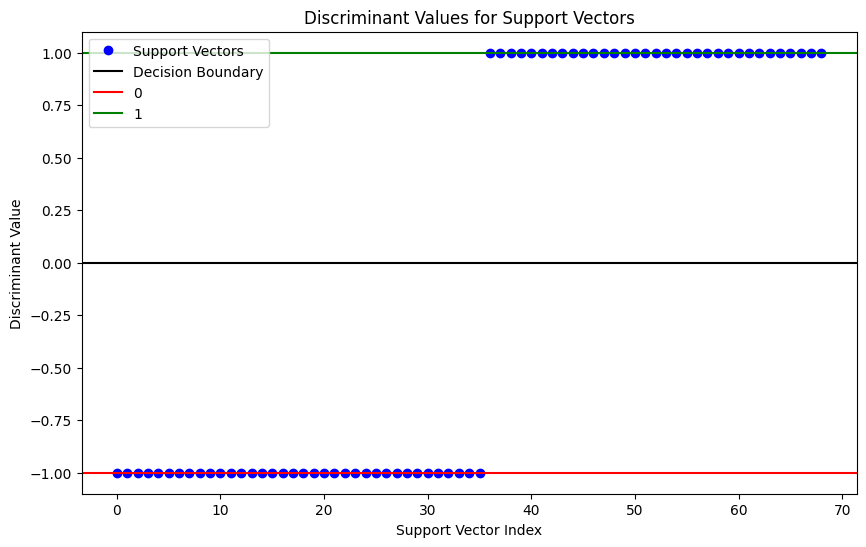

'\nThe plot looks like this becasue it takes in all the support vectors and then the function make a determination \nof each support vector and classifies it as either 0 (red line) or 1 (green line).\n'

In [5]:
decision_values = model.decision_function(support_vectors)

plt.figure(figsize=(10, 6))
plt.plot(range(len(decision_values)), decision_values, 'o', color='blue', label='Support Vectors')
plt.axhline(0, color='black', label='Decision Boundary')
plt.axhline(-1, color='red', label='0')
plt.axhline(1, color='green', label='1')
plt.xlabel("Support Vector Index")
plt.ylabel("Discriminant Value")
plt.title("Discriminant Values for Support Vectors")
plt.legend()
plt.show()

# Reason for why our plot looks this way
"""
The plot looks like this becasue it takes in all the support vectors and then the function make a determination 
of each support vector and classifies it as either 0 (red line) or 1 (green line).
""" 


- Display the w vector of the classifier using the attribute `coef_` as an image and report the intercept
w0

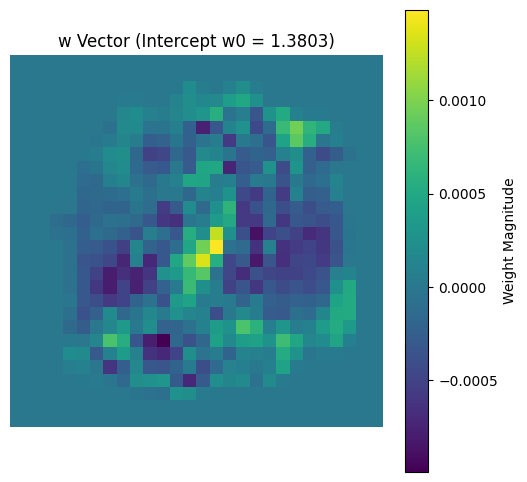

Intercept w0 = 1.3802820778590177


In [6]:
w = model.coef_.reshape(28, 28)
w0 = model.intercept_[0]

plt.figure(figsize=(6, 6))
plt.imshow(w, cmap='viridis')
plt.colorbar(label="Weight Magnitude")
plt.title(f"w Vector (Intercept w0 = {w0:.4f})")
plt.axis('off')
plt.show()

print(f"Intercept w0 = {w0}")

- Reduce the regularization parameter, denoted by C to 1e-8 and repeat the above. What happens to the number of support vectors? What happens to the w vector? Explain.

Number of support vectors: 487


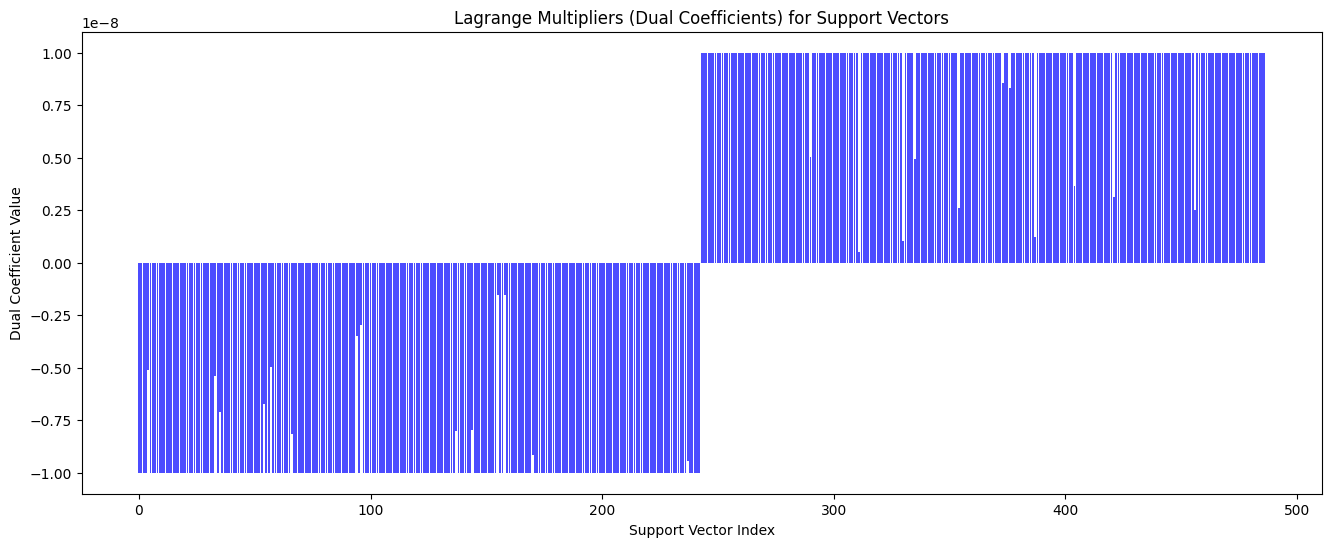

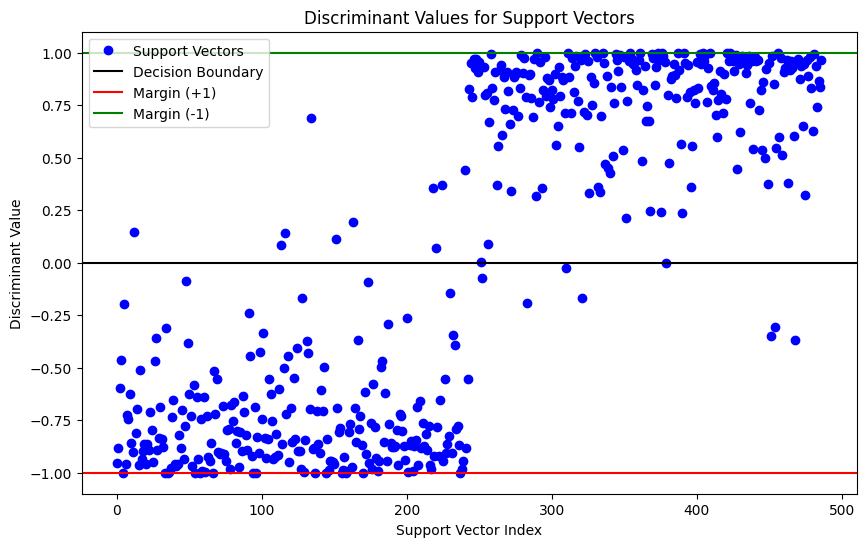


The plot looks like this becasue it takes in all the support vectors and then the function make a determination 
of each support vector and classifies it as either 0 (red line) or 1 (green line).



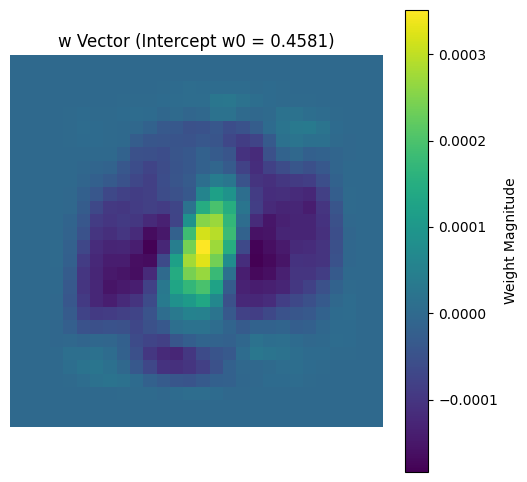

Intercept w0 = 0.4580987162477619

The numnber of support vectors drastically increases.
Then the w vector becomes a bit clearer on the visualization of the decision boundary between 0 and 1.



In [7]:
model = SVC(kernel='linear', C=1E-8)
model.fit(X_train, y_train)

support_vectors = model.support_vectors_
n_support = len(support_vectors)
print(f"Number of support vectors: {n_support}")

# Leaving this out since there are too many graphs to show
# fig, axes = plt.subplots(54, 9, figsize=(12, 4))
# axes = axes.flatten()
# for i, ax in enumerate(axes):
#     ax.imshow(support_vectors[i].reshape(28, 28), cmap='gray')
#     ax.axis('off')
# plt.suptitle("Support Vectors")
# plt.show()

# Dueal coefficients
dual_coef = model.dual_coef_[0] 
support_indices = model.support_
plt.figure(figsize=(16, 6))
plt.bar(range(len(dual_coef)), dual_coef, color='blue', alpha=0.7)
plt.xlabel("Support Vector Index")
plt.ylabel("Dual Coefficient Value")
plt.title("Lagrange Multipliers (Dual Coefficients) for Support Vectors")
plt.show()

# Decision Function
decision_values = model.decision_function(support_vectors)
plt.figure(figsize=(10, 6))
plt.plot(range(len(decision_values)), decision_values, 'o', color='blue', label='Support Vectors')
plt.axhline(0, color='black', label='Decision Boundary')
plt.axhline(-1, color='red', label='Margin (+1)')
plt.axhline(1, color='green', label='Margin (-1)')
plt.xlabel("Support Vector Index")
plt.ylabel("Discriminant Value")
plt.title("Discriminant Values for Support Vectors")
plt.legend()
plt.show()

# Reason for why our plot looks this way
print("""
The plot looks like this becasue it takes in all the support vectors and then the function make a determination 
of each support vector and classifies it as either 0 (red line) or 1 (green line).
""")

# Intercept w0
w = model.coef_.reshape(28, 28)
w0 = model.intercept_[0]

plt.figure(figsize=(6, 6))
plt.imshow(w, cmap='viridis')
plt.colorbar(label="Weight Magnitude")
plt.title(f"w Vector (Intercept w0 = {w0:.4f})")
plt.axis('off')
plt.show()

print(f"Intercept w0 = {w0}")

# Explaination of what happened:
print("""
The numnber of support vectors drastically increases.\nThen the w vector becomes a bit clearer on the visualization of the decision boundary between 0 and 1.
""")


- Using the validation data, determine the optimal value of the regularization parameter. Display the w vector in this case

Optimal C: 0.001
Validation Accuracy for Optimal C: 0.9986


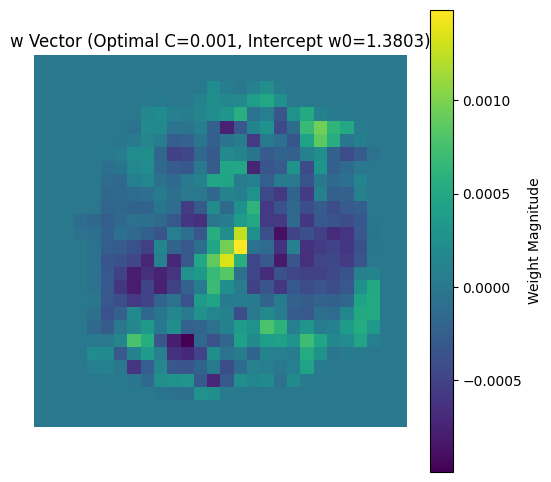

In [43]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
validation_accuracies = []
models = []

# Train SVM for each C and evaluate on the validation set
for C in C_values:
    model = SVC(kernel='linear', C=C)
    model.fit(X_train, y_train)
    models.append(model)
    
    # Predict on validation set
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    validation_accuracies.append(accuracy)

# Find the optimal C (maximizing accuracy)
optimal_index = np.argmax(validation_accuracies)
optimal_C = C_values[optimal_index]
optimal_model = models[optimal_index]

print(f"Optimal C: {optimal_C}")
print(f"Validation Accuracy for Optimal C: {validation_accuracies[optimal_index]:.4f}")

# Display the w vector for the optimal C
w_optimal = optimal_model.coef_.reshape(28, 28)  # Reshape to image
w0_optimal = optimal_model.intercept_[0]

plt.figure(figsize=(6, 6))
plt.imshow(w_optimal, cmap='viridis')
plt.colorbar(label="Weight Magnitude")
plt.title(f"w Vector (Optimal C={optimal_C}, Intercept w0={w0_optimal:.4f})")
plt.axis('off')
plt.show()


- Using score, determine the accuracy of the classification in the 0-1 and 2-3 settings

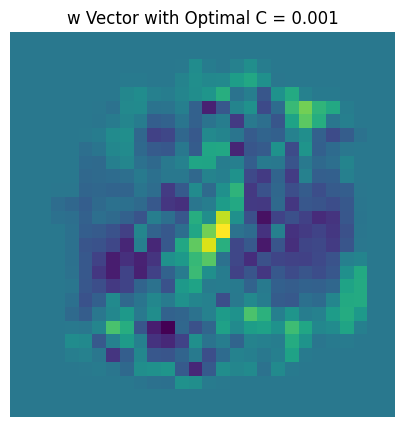

Optimal C: 0.001
Validation Accuracy with Optimal C: 0.9986
Accuracy for 0-1 Classification: 0.9984
Accuracy for 2-3 Classification: 0.9578


In [ ]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
best_C = None
best_accuracy = 0
best_model = None

for C in C_values:
    svm_classifier = SVC(kernel="linear", C=C)
    svm_classifier.fit(X_train, y_train)
    accuracy = svm_classifier.score(X_val, y_val)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_C = C
        best_model = svm_classifier

# Display the w vector for the optimal C
w_vector_optimal = best_model.coef_.reshape(28, 28)
plt.figure(figsize=(5, 5))
plt.imshow(w_vector_optimal, cmap='viridis')
plt.title(f"w Vector with Optimal C = {best_C}")
plt.axis("off")
plt.show()

print(f"Optimal C: {best_C}")
print(f"Validation Accuracy with Optimal C: {best_accuracy:.4f}")

accuracy_01 = best_model.score(X_test, y_test)
print(f"Accuracy for 0-1 Classification: {accuracy_01:.4f}")

# 2-3 Classification
x2 = X[(y == 2)]
x3 = X[(y == 3)]

Xtrain_23 = np.concatenate((x2, x3), axis=0)
ytrain_23 = np.concatenate((np.zeros(x2.shape[0]), np.ones(x3.shape[0])), axis=0)

X_train_23, X_test_23, y_train_23, y_test_23 = train_test_split(Xtrain_23, ytrain_23, test_size=0.3, random_state=1)
X_train_23, X_val_23, y_train_23, y_val_23 = train_test_split(X_train_23, y_train_23, test_size=0.14, random_state=1)

svm_classifier_23 = SVC(kernel="linear", C=best_C)
svm_classifier_23.fit(X_train_23, y_train_23)
accuracy_23 = svm_classifier_23.score(X_test_23, y_test_23)

print(f"Accuracy for 2-3 Classification: {accuracy_23:.4f}")


### Two class classification with kernel classifiers
#### Use `poly` and `rbf` kernels to classify the above data.
- Extract the support vectors and display them as 28x28 images in each case

----- Polynomial Kernel -----
Kernel: poly, Number of support vectors: 249


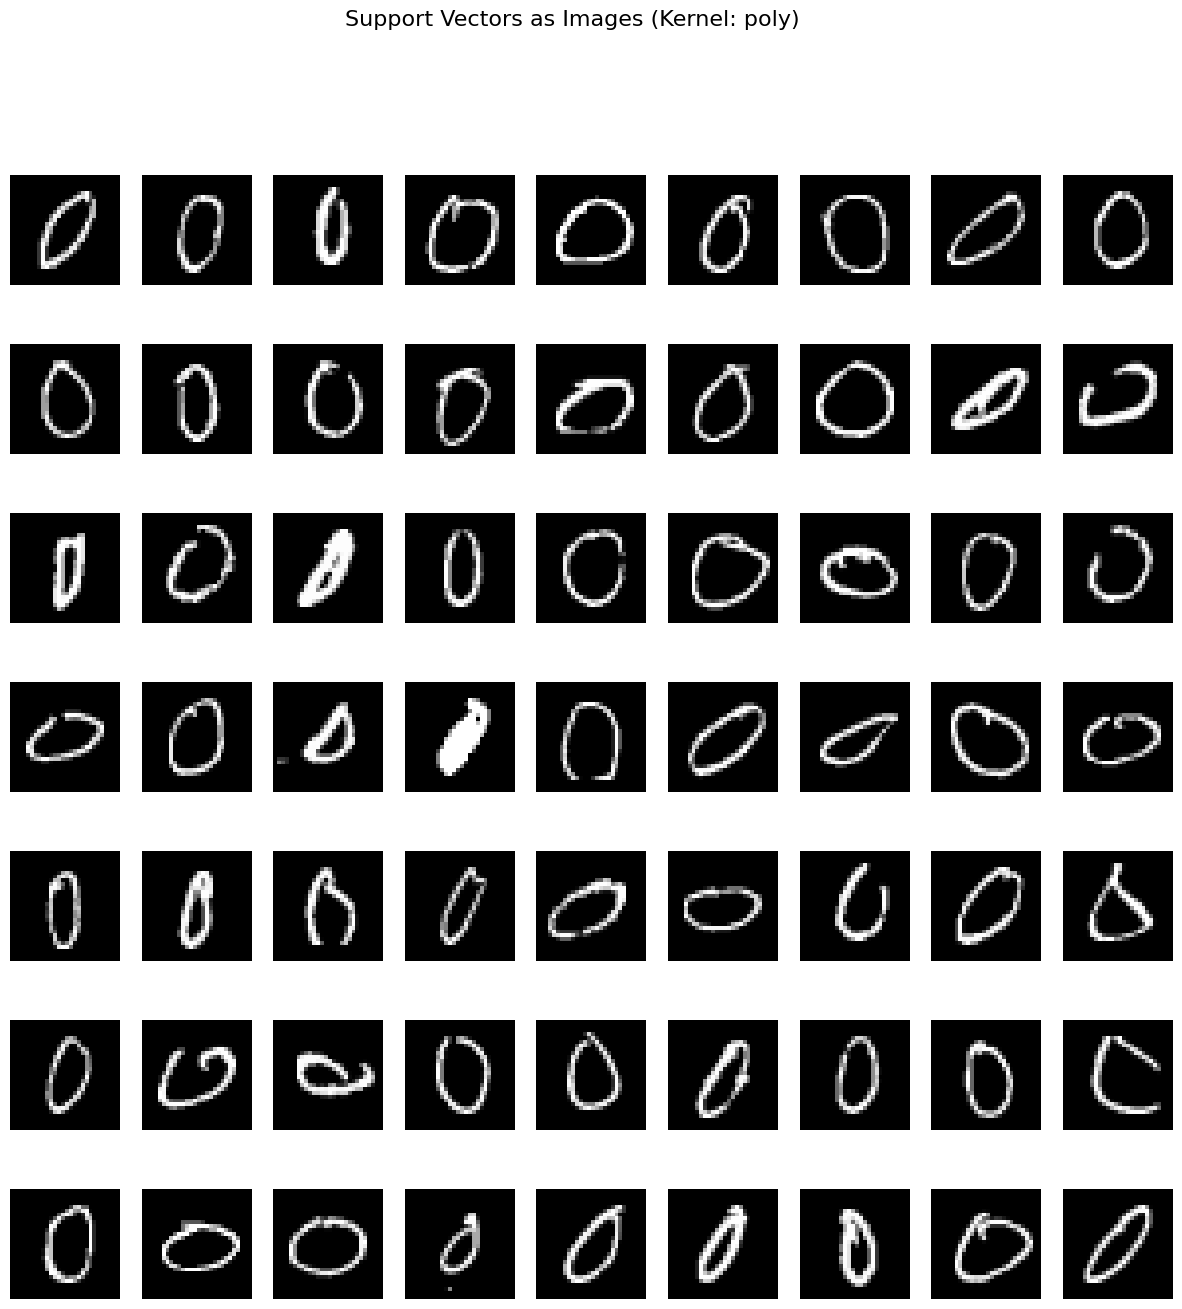

Test Accuracy (Kernel: poly): 99.84%

----- RBF Kernel -----
Kernel: rbf, Number of support vectors: 186


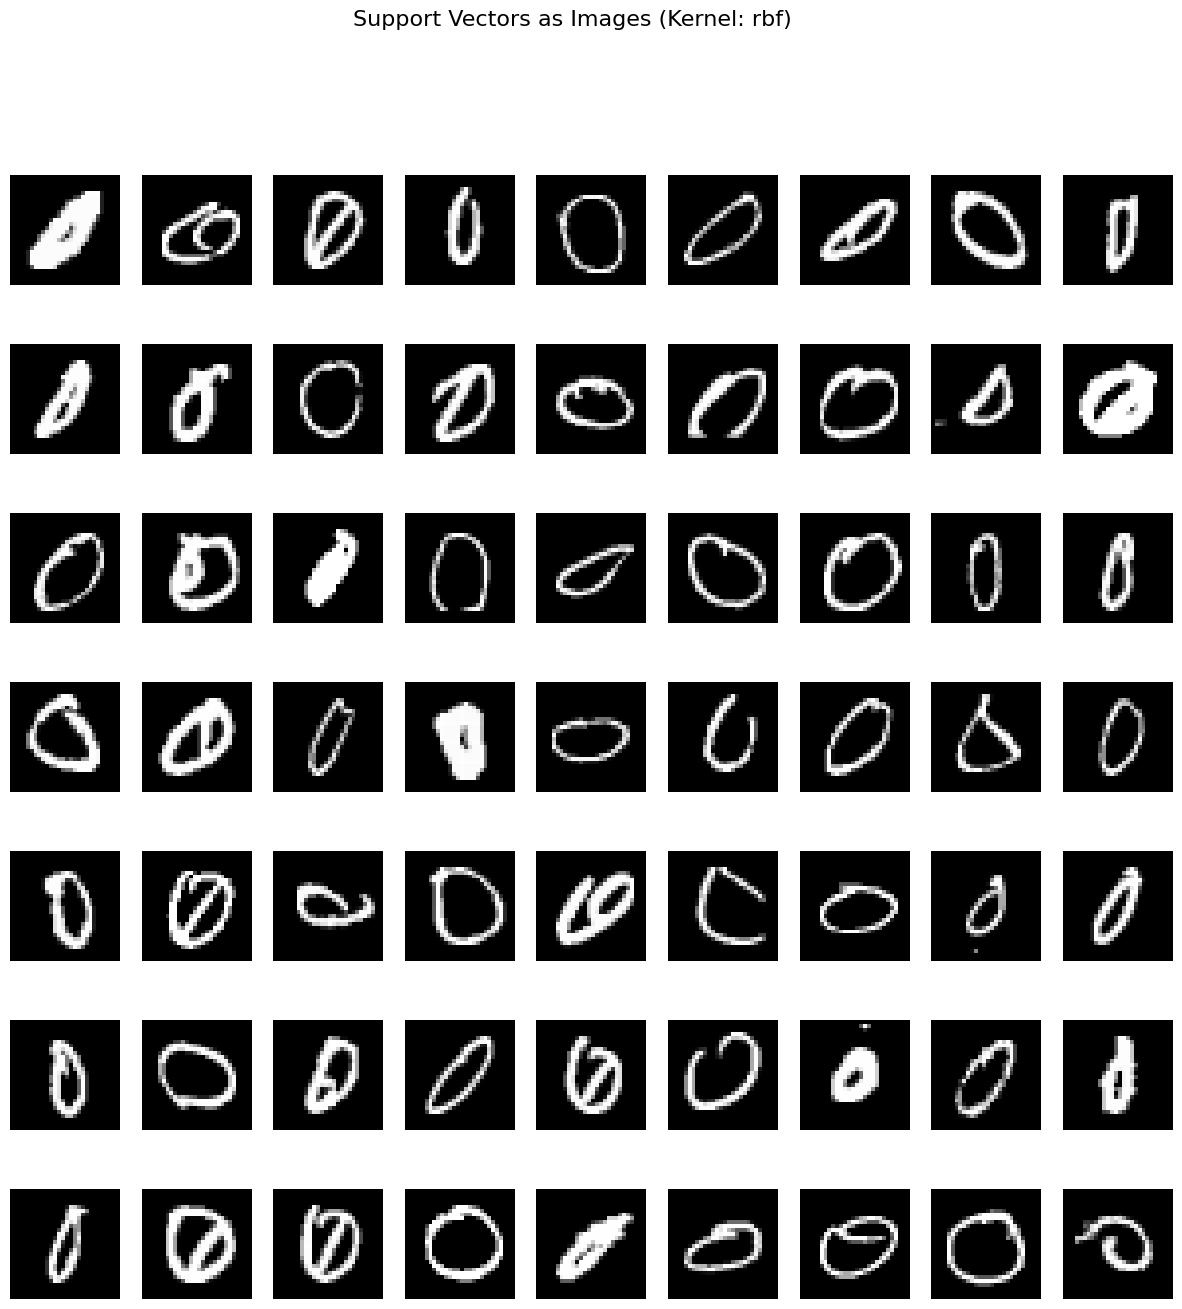

Test Accuracy (Kernel: rbf): 99.98%


In [10]:
# Function to train SVM with specified kernel and display support vectors
def kernel_svm_with_support_vectors(X, y, class1, class2, kernel, **kernel_params):
    # Filter data for the specific classes
    mask = (y == class1) | (y == class2)
    X_filtered = X[mask]
    y_filtered = y[mask]
    y_filtered = (y_filtered == class2).astype(int)  # Map classes to 0 and 1
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)

    # Train SVM with the specified kernel
    model = SVC(kernel=kernel, **kernel_params)
    model.fit(X_train, y_train)

    # Extract support vectors
    support_vectors = model.support_vectors_
    n_support = len(support_vectors)
    print(f"Kernel: {kernel}, Number of support vectors: {n_support}")

    # Display support vectors as 28x28 images
    n_images = min(63, n_support)  # Cap at 63 for visualization
    grid_cols = 9
    grid_rows = int(np.ceil(n_images / grid_cols))
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 15))
    axes = axes.flatten()

    for i, ax in enumerate(axes[:n_images]):
        ax.imshow(support_vectors[i].reshape(28, 28), cmap='gray')
        ax.axis('off')

    # Hide unused axes
    for ax in axes[n_images:]:
        ax.axis('off')

    plt.suptitle(f"Support Vectors as Images (Kernel: {kernel})", fontsize=16)
    plt.show()

    # Evaluate and return accuracy
    accuracy = model.score(X_test, y_test)
    print(f"Test Accuracy (Kernel: {kernel}): {accuracy * 100:.2f}%")
    return model

# Poly kernel classification
print("----- Polynomial Kernel -----")
poly_model = kernel_svm_with_support_vectors(X, y, 0, 1, kernel='poly', degree=3, C=1.0)

# RBF kernel classification
print("\n----- RBF Kernel -----")
rbf_model = kernel_svm_with_support_vectors(X, y, 0, 1, kernel='rbf', C=1.0, gamma='scale')


- Plot the dual coefficients or Lagrange multipliers using the attribute dual_coef_, which corresponds to the weights for the support vectors.
- Use the decision_function function of the SVC to compute the value of the discriminant at the support vectors and plot them. In this case, there is no w vector; the classifier involves the
inner-products in high-dimensional space, which requires the evaluation of kernels with all the
support vectors.
- Using the validation data, determine the optimal value of the regularization parameter. Using
score, determine the accuracy of the classification in the 0-1 and 2-3 settings